# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [18]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

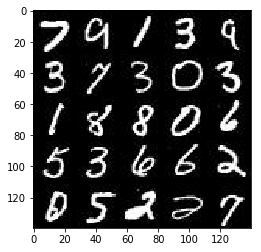

In [19]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

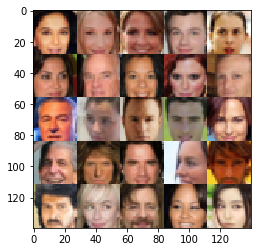

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [21]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, *(image_width, image_height, image_channels)), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name="lr")
    
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [22]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x56
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x112
        
        x3 = tf.layers.conv2d(relu2, 224, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x224

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    input_real, input_z, lr_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr_tensor, beta1)
    
    saver = tf.train.Saver()
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_tensor: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_tensor: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4557... Generator Loss: 0.4377
Epoch 1/2... Discriminator Loss: 0.7280... Generator Loss: 0.8932
Epoch 1/2... Discriminator Loss: 0.6296... Generator Loss: 1.1768
Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 0.7100... Generator Loss: 2.7010
Epoch 1/2... Discriminator Loss: 0.5327... Generator Loss: 1.1878
Epoch 1/2... Discriminator Loss: 0.5726... Generator Loss: 1.2000
Epoch 1/2... Discriminator Loss: 0.6395... Generator Loss: 1.0533
Epoch 1/2... Discriminator Loss: 0.5750... Generator Loss: 1.3488
Epoch 1/2... Discriminator Loss: 0.9297... Generator Loss: 0.6296


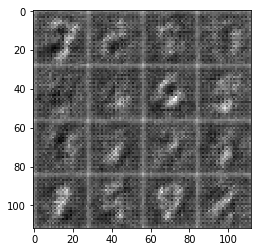

Epoch 1/2... Discriminator Loss: 1.5226... Generator Loss: 0.3018
Epoch 1/2... Discriminator Loss: 0.7244... Generator Loss: 0.9261
Epoch 1/2... Discriminator Loss: 0.6747... Generator Loss: 1.0430
Epoch 1/2... Discriminator Loss: 0.5583... Generator Loss: 1.4798
Epoch 1/2... Discriminator Loss: 0.5267... Generator Loss: 1.7927
Epoch 1/2... Discriminator Loss: 0.4890... Generator Loss: 1.7735
Epoch 1/2... Discriminator Loss: 0.3619... Generator Loss: 1.9353
Epoch 1/2... Discriminator Loss: 0.4352... Generator Loss: 1.4634
Epoch 1/2... Discriminator Loss: 0.3714... Generator Loss: 1.8214
Epoch 1/2... Discriminator Loss: 0.4166... Generator Loss: 2.1439


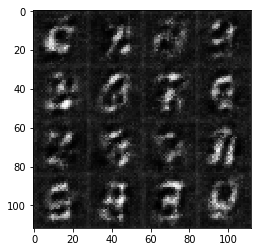

Epoch 1/2... Discriminator Loss: 0.3658... Generator Loss: 1.5689
Epoch 1/2... Discriminator Loss: 0.2730... Generator Loss: 1.9847
Epoch 1/2... Discriminator Loss: 0.3256... Generator Loss: 1.7194
Epoch 1/2... Discriminator Loss: 1.4519... Generator Loss: 0.3277
Epoch 1/2... Discriminator Loss: 0.1966... Generator Loss: 2.2775
Epoch 1/2... Discriminator Loss: 0.1584... Generator Loss: 2.4465
Epoch 1/2... Discriminator Loss: 0.1832... Generator Loss: 2.1623
Epoch 1/2... Discriminator Loss: 0.1521... Generator Loss: 2.4987
Epoch 1/2... Discriminator Loss: 0.1973... Generator Loss: 2.1552
Epoch 1/2... Discriminator Loss: 0.1115... Generator Loss: 3.1473


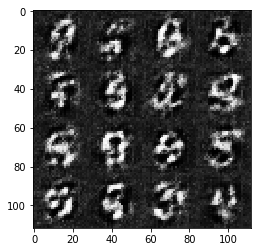

Epoch 1/2... Discriminator Loss: 0.0986... Generator Loss: 2.9146
Epoch 1/2... Discriminator Loss: 0.1136... Generator Loss: 2.8111
Epoch 1/2... Discriminator Loss: 0.2964... Generator Loss: 1.5717
Epoch 1/2... Discriminator Loss: 0.1011... Generator Loss: 2.9341
Epoch 1/2... Discriminator Loss: 1.5695... Generator Loss: 6.6959
Epoch 1/2... Discriminator Loss: 0.1781... Generator Loss: 2.3651
Epoch 1/2... Discriminator Loss: 0.1845... Generator Loss: 2.2733
Epoch 1/2... Discriminator Loss: 0.2258... Generator Loss: 2.4627
Epoch 1/2... Discriminator Loss: 0.1986... Generator Loss: 2.5858
Epoch 1/2... Discriminator Loss: 0.8749... Generator Loss: 0.6706


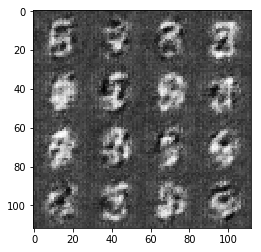

Epoch 1/2... Discriminator Loss: 0.2947... Generator Loss: 1.8030
Epoch 1/2... Discriminator Loss: 0.4336... Generator Loss: 1.2949
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 0.4552
Epoch 1/2... Discriminator Loss: 0.2326... Generator Loss: 1.9240
Epoch 1/2... Discriminator Loss: 0.2013... Generator Loss: 2.4054
Epoch 1/2... Discriminator Loss: 0.4755... Generator Loss: 1.1660
Epoch 1/2... Discriminator Loss: 0.2514... Generator Loss: 1.9098
Epoch 1/2... Discriminator Loss: 0.2078... Generator Loss: 2.1443
Epoch 1/2... Discriminator Loss: 0.2310... Generator Loss: 2.1676
Epoch 1/2... Discriminator Loss: 0.1872... Generator Loss: 2.3985


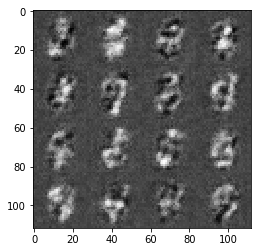

Epoch 1/2... Discriminator Loss: 0.1540... Generator Loss: 2.6802
Epoch 1/2... Discriminator Loss: 0.2821... Generator Loss: 1.7653
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 1.4326
Epoch 1/2... Discriminator Loss: 0.1320... Generator Loss: 3.0120
Epoch 1/2... Discriminator Loss: 0.2093... Generator Loss: 2.0114
Epoch 1/2... Discriminator Loss: 0.1592... Generator Loss: 2.3518
Epoch 1/2... Discriminator Loss: 0.1389... Generator Loss: 2.4848
Epoch 1/2... Discriminator Loss: 0.1317... Generator Loss: 2.7613
Epoch 1/2... Discriminator Loss: 0.1873... Generator Loss: 2.1993
Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 7.4504


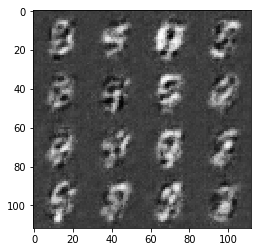

Epoch 1/2... Discriminator Loss: 0.1401... Generator Loss: 2.6629
Epoch 1/2... Discriminator Loss: 0.1576... Generator Loss: 2.5148
Epoch 1/2... Discriminator Loss: 0.1330... Generator Loss: 2.8039
Epoch 1/2... Discriminator Loss: 0.1264... Generator Loss: 2.8300
Epoch 1/2... Discriminator Loss: 0.2470... Generator Loss: 2.0169
Epoch 1/2... Discriminator Loss: 0.1250... Generator Loss: 2.7268
Epoch 1/2... Discriminator Loss: 0.1058... Generator Loss: 2.8450
Epoch 1/2... Discriminator Loss: 0.1115... Generator Loss: 3.0587
Epoch 1/2... Discriminator Loss: 0.1204... Generator Loss: 2.8197
Epoch 1/2... Discriminator Loss: 0.1017... Generator Loss: 3.2466


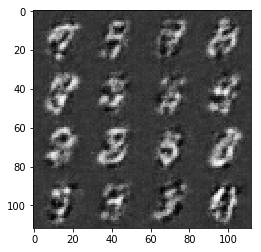

Epoch 1/2... Discriminator Loss: 0.1247... Generator Loss: 2.8032
Epoch 1/2... Discriminator Loss: 0.0849... Generator Loss: 3.3118
Epoch 1/2... Discriminator Loss: 0.1006... Generator Loss: 3.0088
Epoch 1/2... Discriminator Loss: 0.0967... Generator Loss: 3.2804
Epoch 1/2... Discriminator Loss: 0.0500... Generator Loss: 3.8233
Epoch 1/2... Discriminator Loss: 0.0747... Generator Loss: 3.2336
Epoch 1/2... Discriminator Loss: 0.0801... Generator Loss: 3.1433
Epoch 1/2... Discriminator Loss: 0.1259... Generator Loss: 2.6711
Epoch 1/2... Discriminator Loss: 0.0848... Generator Loss: 3.4163
Epoch 1/2... Discriminator Loss: 0.0863... Generator Loss: 2.9884


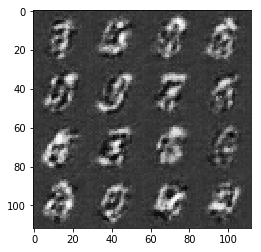

Epoch 1/2... Discriminator Loss: 0.0885... Generator Loss: 2.9690
Epoch 1/2... Discriminator Loss: 0.0658... Generator Loss: 3.4754
Epoch 1/2... Discriminator Loss: 0.0910... Generator Loss: 2.9789
Epoch 1/2... Discriminator Loss: 0.0790... Generator Loss: 3.1858
Epoch 1/2... Discriminator Loss: 0.0956... Generator Loss: 3.0307
Epoch 1/2... Discriminator Loss: 0.0821... Generator Loss: 3.5571
Epoch 1/2... Discriminator Loss: 0.2483... Generator Loss: 4.3133
Epoch 1/2... Discriminator Loss: 0.1722... Generator Loss: 2.5150
Epoch 1/2... Discriminator Loss: 0.0548... Generator Loss: 3.6385
Epoch 1/2... Discriminator Loss: 0.0599... Generator Loss: 3.6722


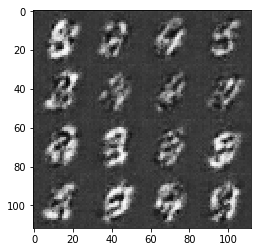

Epoch 1/2... Discriminator Loss: 0.1146... Generator Loss: 2.9266
Epoch 1/2... Discriminator Loss: 0.0928... Generator Loss: 2.9440
Epoch 1/2... Discriminator Loss: 0.1120... Generator Loss: 2.8767
Epoch 1/2... Discriminator Loss: 0.0836... Generator Loss: 3.5477
Epoch 1/2... Discriminator Loss: 0.0556... Generator Loss: 3.7109
Epoch 1/2... Discriminator Loss: 0.0920... Generator Loss: 3.2532
Epoch 1/2... Discriminator Loss: 0.0778... Generator Loss: 3.4860
Epoch 1/2... Discriminator Loss: 0.0621... Generator Loss: 3.9074
Epoch 1/2... Discriminator Loss: 0.0744... Generator Loss: 3.2837
Epoch 1/2... Discriminator Loss: 0.0753... Generator Loss: 3.2518


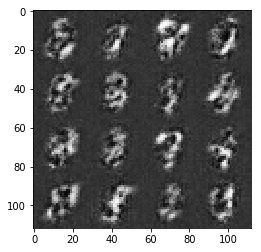

Epoch 1/2... Discriminator Loss: 0.0573... Generator Loss: 3.8793
Epoch 1/2... Discriminator Loss: 0.0832... Generator Loss: 3.0666
Epoch 1/2... Discriminator Loss: 0.0617... Generator Loss: 3.4065
Epoch 1/2... Discriminator Loss: 0.0898... Generator Loss: 3.1813
Epoch 1/2... Discriminator Loss: 0.0888... Generator Loss: 3.1501
Epoch 1/2... Discriminator Loss: 0.0598... Generator Loss: 3.7058
Epoch 1/2... Discriminator Loss: 0.0675... Generator Loss: 3.5812
Epoch 1/2... Discriminator Loss: 0.0461... Generator Loss: 3.7929
Epoch 1/2... Discriminator Loss: 0.1402... Generator Loss: 2.4418
Epoch 1/2... Discriminator Loss: 0.1172... Generator Loss: 2.9882


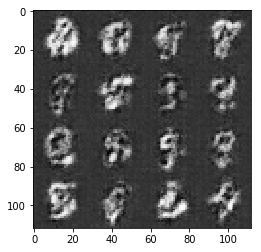

Epoch 1/2... Discriminator Loss: 0.0931... Generator Loss: 3.0315
Epoch 1/2... Discriminator Loss: 0.0688... Generator Loss: 3.7564
Epoch 1/2... Discriminator Loss: 0.0744... Generator Loss: 3.8206
Epoch 1/2... Discriminator Loss: 0.0584... Generator Loss: 3.7047
Epoch 1/2... Discriminator Loss: 0.0611... Generator Loss: 3.6645
Epoch 1/2... Discriminator Loss: 0.0745... Generator Loss: 3.2675
Epoch 1/2... Discriminator Loss: 0.1096... Generator Loss: 4.2815
Epoch 1/2... Discriminator Loss: 0.3254... Generator Loss: 6.0455
Epoch 1/2... Discriminator Loss: 0.2274... Generator Loss: 2.9756
Epoch 1/2... Discriminator Loss: 0.1043... Generator Loss: 3.1547


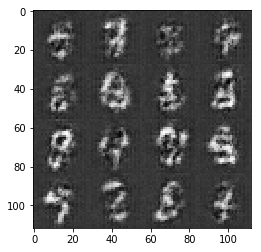

Epoch 1/2... Discriminator Loss: 0.1056... Generator Loss: 2.9039
Epoch 1/2... Discriminator Loss: 0.1216... Generator Loss: 2.9606
Epoch 1/2... Discriminator Loss: 0.1214... Generator Loss: 2.8890
Epoch 1/2... Discriminator Loss: 0.0762... Generator Loss: 3.3877
Epoch 1/2... Discriminator Loss: 0.0774... Generator Loss: 3.2609
Epoch 1/2... Discriminator Loss: 0.0907... Generator Loss: 3.0346
Epoch 1/2... Discriminator Loss: 0.0740... Generator Loss: 3.5663
Epoch 1/2... Discriminator Loss: 0.0694... Generator Loss: 3.2250
Epoch 1/2... Discriminator Loss: 0.1529... Generator Loss: 2.4564
Epoch 1/2... Discriminator Loss: 0.0674... Generator Loss: 3.2446


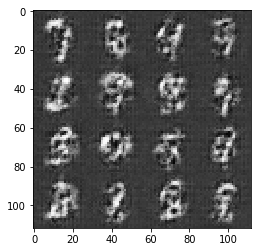

Epoch 1/2... Discriminator Loss: 0.1162... Generator Loss: 2.8351
Epoch 1/2... Discriminator Loss: 0.1011... Generator Loss: 2.7563
Epoch 1/2... Discriminator Loss: 0.0631... Generator Loss: 3.4362
Epoch 1/2... Discriminator Loss: 0.0733... Generator Loss: 3.4443
Epoch 1/2... Discriminator Loss: 0.0987... Generator Loss: 2.7924
Epoch 1/2... Discriminator Loss: 0.0908... Generator Loss: 3.0594
Epoch 1/2... Discriminator Loss: 0.0812... Generator Loss: 3.3826
Epoch 1/2... Discriminator Loss: 0.0845... Generator Loss: 3.0202
Epoch 1/2... Discriminator Loss: 0.0728... Generator Loss: 3.2867
Epoch 1/2... Discriminator Loss: 0.0633... Generator Loss: 3.6243


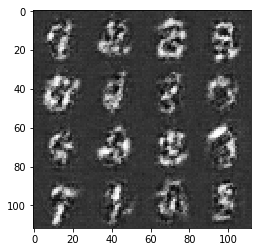

Epoch 1/2... Discriminator Loss: 0.0486... Generator Loss: 3.5899
Epoch 1/2... Discriminator Loss: 0.0553... Generator Loss: 3.6896
Epoch 1/2... Discriminator Loss: 0.0367... Generator Loss: 4.1632
Epoch 1/2... Discriminator Loss: 0.0397... Generator Loss: 4.1610
Epoch 1/2... Discriminator Loss: 0.0372... Generator Loss: 3.7183
Epoch 1/2... Discriminator Loss: 0.0729... Generator Loss: 3.4628
Epoch 1/2... Discriminator Loss: 0.0992... Generator Loss: 2.9789
Epoch 1/2... Discriminator Loss: 0.0533... Generator Loss: 3.5757
Epoch 1/2... Discriminator Loss: 0.0463... Generator Loss: 3.7703
Epoch 1/2... Discriminator Loss: 0.0550... Generator Loss: 3.5311


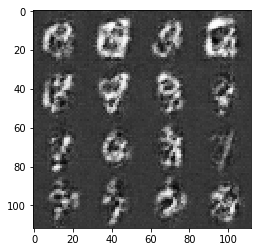

Epoch 1/2... Discriminator Loss: 0.0692... Generator Loss: 3.5459
Epoch 1/2... Discriminator Loss: 0.0532... Generator Loss: 3.8276
Epoch 1/2... Discriminator Loss: 0.0672... Generator Loss: 3.4335
Epoch 1/2... Discriminator Loss: 0.0634... Generator Loss: 3.5061
Epoch 1/2... Discriminator Loss: 0.0700... Generator Loss: 3.2157
Epoch 1/2... Discriminator Loss: 0.0794... Generator Loss: 3.2660
Epoch 1/2... Discriminator Loss: 0.0492... Generator Loss: 3.7755
Epoch 1/2... Discriminator Loss: 0.0503... Generator Loss: 3.9385
Epoch 1/2... Discriminator Loss: 0.0418... Generator Loss: 3.6741
Epoch 1/2... Discriminator Loss: 0.0787... Generator Loss: 3.3621


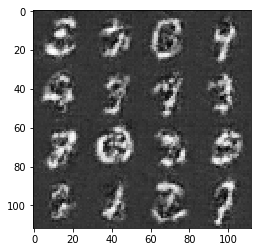

Epoch 1/2... Discriminator Loss: 0.0327... Generator Loss: 4.1924
Epoch 1/2... Discriminator Loss: 0.0440... Generator Loss: 3.8384
Epoch 1/2... Discriminator Loss: 0.0461... Generator Loss: 3.6651
Epoch 1/2... Discriminator Loss: 0.0591... Generator Loss: 3.6911
Epoch 1/2... Discriminator Loss: 0.0343... Generator Loss: 4.0622
Epoch 1/2... Discriminator Loss: 0.0259... Generator Loss: 4.6350
Epoch 1/2... Discriminator Loss: 0.0676... Generator Loss: 3.3581
Epoch 1/2... Discriminator Loss: 0.0446... Generator Loss: 3.6237
Epoch 1/2... Discriminator Loss: 0.0640... Generator Loss: 3.7070
Epoch 1/2... Discriminator Loss: 0.0361... Generator Loss: 4.0194


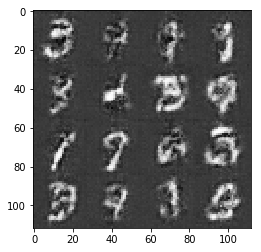

Epoch 1/2... Discriminator Loss: 0.0372... Generator Loss: 4.2008
Epoch 1/2... Discriminator Loss: 0.0368... Generator Loss: 4.6690
Epoch 1/2... Discriminator Loss: 0.0193... Generator Loss: 4.8376
Epoch 1/2... Discriminator Loss: 0.0340... Generator Loss: 4.0890
Epoch 1/2... Discriminator Loss: 0.0544... Generator Loss: 3.9734
Epoch 1/2... Discriminator Loss: 0.0616... Generator Loss: 3.4421
Epoch 1/2... Discriminator Loss: 0.0232... Generator Loss: 4.4194
Epoch 1/2... Discriminator Loss: 0.8064... Generator Loss: 0.8662
Epoch 1/2... Discriminator Loss: 0.0333... Generator Loss: 4.1140
Epoch 1/2... Discriminator Loss: 0.0582... Generator Loss: 3.4729


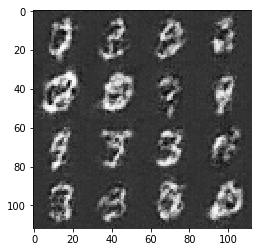

Epoch 1/2... Discriminator Loss: 0.0317... Generator Loss: 4.4385
Epoch 1/2... Discriminator Loss: 0.0335... Generator Loss: 4.0734
Epoch 1/2... Discriminator Loss: 0.0718... Generator Loss: 3.5655
Epoch 1/2... Discriminator Loss: 0.0391... Generator Loss: 4.0757
Epoch 1/2... Discriminator Loss: 0.0145... Generator Loss: 4.9109
Epoch 1/2... Discriminator Loss: 0.0359... Generator Loss: 4.1463
Epoch 1/2... Discriminator Loss: 0.0318... Generator Loss: 3.9518
Epoch 2/2... Discriminator Loss: 0.0389... Generator Loss: 3.9348
Epoch 2/2... Discriminator Loss: 0.0515... Generator Loss: 3.5174
Epoch 2/2... Discriminator Loss: 0.0457... Generator Loss: 3.7573


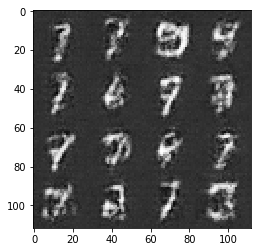

Epoch 2/2... Discriminator Loss: 0.1093... Generator Loss: 2.6386
Epoch 2/2... Discriminator Loss: 0.0358... Generator Loss: 4.1321
Epoch 2/2... Discriminator Loss: 0.0236... Generator Loss: 4.9631
Epoch 2/2... Discriminator Loss: 0.0300... Generator Loss: 4.3590
Epoch 2/2... Discriminator Loss: 0.0482... Generator Loss: 3.6668
Epoch 2/2... Discriminator Loss: 0.0292... Generator Loss: 4.0442
Epoch 2/2... Discriminator Loss: 0.0662... Generator Loss: 3.3812
Epoch 2/2... Discriminator Loss: 0.0302... Generator Loss: 4.1616
Epoch 2/2... Discriminator Loss: 0.0286... Generator Loss: 4.2113
Epoch 2/2... Discriminator Loss: 0.0520... Generator Loss: 3.4217


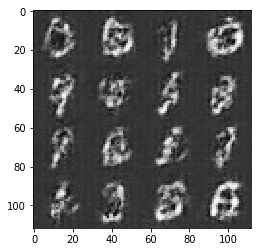

Epoch 2/2... Discriminator Loss: 0.0624... Generator Loss: 3.6909
Epoch 2/2... Discriminator Loss: 0.0228... Generator Loss: 4.6121
Epoch 2/2... Discriminator Loss: 0.0246... Generator Loss: 4.1226
Epoch 2/2... Discriminator Loss: 0.0229... Generator Loss: 4.2820
Epoch 2/2... Discriminator Loss: 0.0432... Generator Loss: 3.9564
Epoch 2/2... Discriminator Loss: 0.0505... Generator Loss: 3.7608
Epoch 2/2... Discriminator Loss: 0.0373... Generator Loss: 4.0198
Epoch 2/2... Discriminator Loss: 0.0999... Generator Loss: 2.9919
Epoch 2/2... Discriminator Loss: 0.0786... Generator Loss: 3.1712
Epoch 2/2... Discriminator Loss: 0.0356... Generator Loss: 4.0098


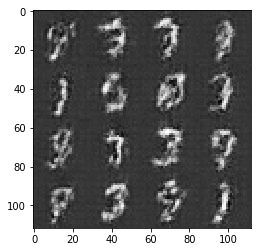

Epoch 2/2... Discriminator Loss: 0.0146... Generator Loss: 5.2067
Epoch 2/2... Discriminator Loss: 0.4971... Generator Loss: 1.4409
Epoch 2/2... Discriminator Loss: 0.3655... Generator Loss: 2.1197
Epoch 2/2... Discriminator Loss: 0.2205... Generator Loss: 2.4291
Epoch 2/2... Discriminator Loss: 0.2147... Generator Loss: 2.0803
Epoch 2/2... Discriminator Loss: 0.1758... Generator Loss: 2.8842
Epoch 2/2... Discriminator Loss: 0.0814... Generator Loss: 3.7314
Epoch 2/2... Discriminator Loss: 0.1900... Generator Loss: 2.2209
Epoch 2/2... Discriminator Loss: 0.0866... Generator Loss: 3.1068
Epoch 2/2... Discriminator Loss: 0.0955... Generator Loss: 3.3316


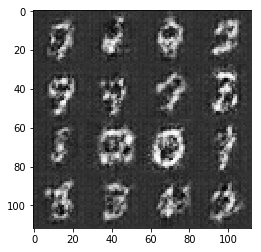

Epoch 2/2... Discriminator Loss: 0.0838... Generator Loss: 3.0278
Epoch 2/2... Discriminator Loss: 0.0791... Generator Loss: 3.4179
Epoch 2/2... Discriminator Loss: 0.1066... Generator Loss: 2.9076
Epoch 2/2... Discriminator Loss: 0.0579... Generator Loss: 3.4629
Epoch 2/2... Discriminator Loss: 0.1047... Generator Loss: 2.8299
Epoch 2/2... Discriminator Loss: 0.1322... Generator Loss: 2.6878
Epoch 2/2... Discriminator Loss: 0.1341... Generator Loss: 2.6855
Epoch 2/2... Discriminator Loss: 0.0831... Generator Loss: 2.8522
Epoch 2/2... Discriminator Loss: 0.0334... Generator Loss: 4.1284
Epoch 2/2... Discriminator Loss: 0.0800... Generator Loss: 3.1798


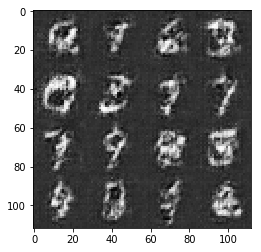

Epoch 2/2... Discriminator Loss: 0.0922... Generator Loss: 2.9580
Epoch 2/2... Discriminator Loss: 0.0750... Generator Loss: 3.2897
Epoch 2/2... Discriminator Loss: 0.0596... Generator Loss: 3.3020
Epoch 2/2... Discriminator Loss: 0.0664... Generator Loss: 3.0615
Epoch 2/2... Discriminator Loss: 0.0592... Generator Loss: 3.3588
Epoch 2/2... Discriminator Loss: 0.0902... Generator Loss: 3.0087
Epoch 2/2... Discriminator Loss: 0.1100... Generator Loss: 2.7146
Epoch 2/2... Discriminator Loss: 0.0545... Generator Loss: 3.4777
Epoch 2/2... Discriminator Loss: 0.0310... Generator Loss: 4.0861
Epoch 2/2... Discriminator Loss: 0.0573... Generator Loss: 3.4502


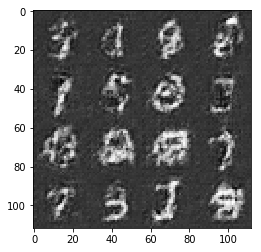

Epoch 2/2... Discriminator Loss: 0.0578... Generator Loss: 3.3925
Epoch 2/2... Discriminator Loss: 0.0536... Generator Loss: 3.3745
Epoch 2/2... Discriminator Loss: 0.0501... Generator Loss: 3.5268
Epoch 2/2... Discriminator Loss: 0.0549... Generator Loss: 3.3642
Epoch 2/2... Discriminator Loss: 0.0809... Generator Loss: 2.9575
Epoch 2/2... Discriminator Loss: 0.0421... Generator Loss: 3.9558
Epoch 2/2... Discriminator Loss: 0.0304... Generator Loss: 4.0334
Epoch 2/2... Discriminator Loss: 0.0591... Generator Loss: 3.5568
Epoch 2/2... Discriminator Loss: 0.0629... Generator Loss: 3.2402
Epoch 2/2... Discriminator Loss: 0.0651... Generator Loss: 3.4495


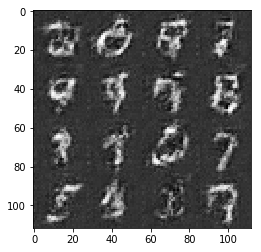

Epoch 2/2... Discriminator Loss: 0.0889... Generator Loss: 2.9586
Epoch 2/2... Discriminator Loss: 0.0685... Generator Loss: 3.2241
Epoch 2/2... Discriminator Loss: 0.0664... Generator Loss: 3.3724
Epoch 2/2... Discriminator Loss: 0.0696... Generator Loss: 2.9340
Epoch 2/2... Discriminator Loss: 0.0872... Generator Loss: 3.1782
Epoch 2/2... Discriminator Loss: 0.0706... Generator Loss: 3.2671
Epoch 2/2... Discriminator Loss: 0.1245... Generator Loss: 2.5104
Epoch 2/2... Discriminator Loss: 0.0462... Generator Loss: 3.4912
Epoch 2/2... Discriminator Loss: 0.0586... Generator Loss: 3.5629
Epoch 2/2... Discriminator Loss: 0.0568... Generator Loss: 3.5860


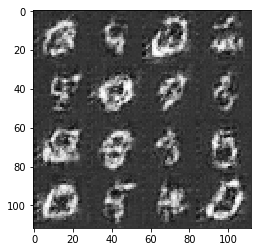

Epoch 2/2... Discriminator Loss: 0.0491... Generator Loss: 3.6814
Epoch 2/2... Discriminator Loss: 0.0562... Generator Loss: 3.3360
Epoch 2/2... Discriminator Loss: 0.0295... Generator Loss: 4.2803
Epoch 2/2... Discriminator Loss: 0.0401... Generator Loss: 3.9510
Epoch 2/2... Discriminator Loss: 0.0755... Generator Loss: 3.0676
Epoch 2/2... Discriminator Loss: 0.0525... Generator Loss: 3.5286
Epoch 2/2... Discriminator Loss: 0.0544... Generator Loss: 3.5287
Epoch 2/2... Discriminator Loss: 0.0716... Generator Loss: 3.1401
Epoch 2/2... Discriminator Loss: 0.0938... Generator Loss: 2.8591
Epoch 2/2... Discriminator Loss: 0.1190... Generator Loss: 2.6002


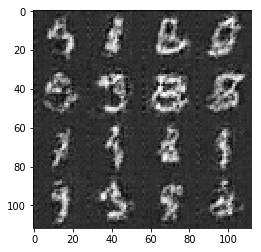

Epoch 2/2... Discriminator Loss: 0.0532... Generator Loss: 3.8003
Epoch 2/2... Discriminator Loss: 0.1017... Generator Loss: 2.9392
Epoch 2/2... Discriminator Loss: 0.1613... Generator Loss: 2.4252
Epoch 2/2... Discriminator Loss: 0.0776... Generator Loss: 3.2604
Epoch 2/2... Discriminator Loss: 0.1085... Generator Loss: 2.6865
Epoch 2/2... Discriminator Loss: 0.0667... Generator Loss: 3.0696
Epoch 2/2... Discriminator Loss: 0.2441... Generator Loss: 1.8987
Epoch 2/2... Discriminator Loss: 0.0451... Generator Loss: 3.6108
Epoch 2/2... Discriminator Loss: 0.0707... Generator Loss: 3.2629
Epoch 2/2... Discriminator Loss: 0.0544... Generator Loss: 3.5631


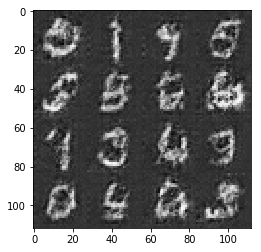

Epoch 2/2... Discriminator Loss: 0.1213... Generator Loss: 2.5932
Epoch 2/2... Discriminator Loss: 0.9453... Generator Loss: 10.7593
Epoch 2/2... Discriminator Loss: 0.5724... Generator Loss: 1.4510
Epoch 2/2... Discriminator Loss: 0.3873... Generator Loss: 1.7781
Epoch 2/2... Discriminator Loss: 0.2361... Generator Loss: 3.7762
Epoch 2/2... Discriminator Loss: 0.2087... Generator Loss: 2.2380
Epoch 2/2... Discriminator Loss: 0.1732... Generator Loss: 2.3962
Epoch 2/2... Discriminator Loss: 0.1655... Generator Loss: 2.2588
Epoch 2/2... Discriminator Loss: 0.0948... Generator Loss: 2.8970
Epoch 2/2... Discriminator Loss: 0.1101... Generator Loss: 3.1525


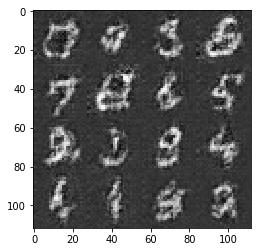

Epoch 2/2... Discriminator Loss: 0.2009... Generator Loss: 1.9673
Epoch 2/2... Discriminator Loss: 0.1155... Generator Loss: 2.6415
Epoch 2/2... Discriminator Loss: 0.1571... Generator Loss: 2.3258
Epoch 2/2... Discriminator Loss: 0.0995... Generator Loss: 2.9018
Epoch 2/2... Discriminator Loss: 0.1297... Generator Loss: 2.5480
Epoch 2/2... Discriminator Loss: 0.1469... Generator Loss: 2.3186
Epoch 2/2... Discriminator Loss: 0.0598... Generator Loss: 3.1346
Epoch 2/2... Discriminator Loss: 0.0743... Generator Loss: 3.3038
Epoch 2/2... Discriminator Loss: 0.0723... Generator Loss: 3.1982
Epoch 2/2... Discriminator Loss: 0.0369... Generator Loss: 3.8273


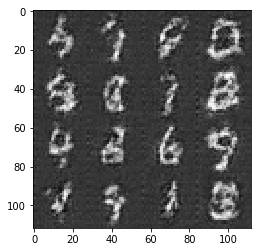

Epoch 2/2... Discriminator Loss: 0.1442... Generator Loss: 2.2228
Epoch 2/2... Discriminator Loss: 0.0592... Generator Loss: 3.5385
Epoch 2/2... Discriminator Loss: 0.1163... Generator Loss: 2.7161
Epoch 2/2... Discriminator Loss: 0.0987... Generator Loss: 2.9251
Epoch 2/2... Discriminator Loss: 0.1485... Generator Loss: 2.5251
Epoch 2/2... Discriminator Loss: 0.0494... Generator Loss: 3.5638
Epoch 2/2... Discriminator Loss: 0.0597... Generator Loss: 3.3189
Epoch 2/2... Discriminator Loss: 0.1056... Generator Loss: 2.8266
Epoch 2/2... Discriminator Loss: 0.0645... Generator Loss: 3.2479
Epoch 2/2... Discriminator Loss: 0.0831... Generator Loss: 2.9776


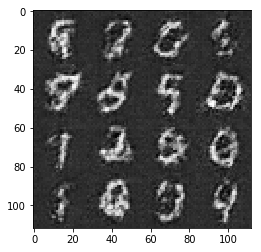

Epoch 2/2... Discriminator Loss: 0.0944... Generator Loss: 2.7223
Epoch 2/2... Discriminator Loss: 0.0361... Generator Loss: 3.8026
Epoch 2/2... Discriminator Loss: 0.1580... Generator Loss: 2.3049
Epoch 2/2... Discriminator Loss: 0.0866... Generator Loss: 2.9158
Epoch 2/2... Discriminator Loss: 0.0568... Generator Loss: 3.3455
Epoch 2/2... Discriminator Loss: 0.1252... Generator Loss: 2.7229
Epoch 2/2... Discriminator Loss: 0.0704... Generator Loss: 3.0411
Epoch 2/2... Discriminator Loss: 0.0641... Generator Loss: 3.1409
Epoch 2/2... Discriminator Loss: 0.1292... Generator Loss: 2.5924
Epoch 2/2... Discriminator Loss: 0.0684... Generator Loss: 3.2975


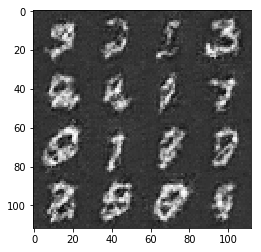

Epoch 2/2... Discriminator Loss: 0.0882... Generator Loss: 2.8965
Epoch 2/2... Discriminator Loss: 0.3594... Generator Loss: 1.5505
Epoch 2/2... Discriminator Loss: 0.0873... Generator Loss: 2.9201
Epoch 2/2... Discriminator Loss: 0.0998... Generator Loss: 2.7833
Epoch 2/2... Discriminator Loss: 0.0650... Generator Loss: 3.2304
Epoch 2/2... Discriminator Loss: 0.0337... Generator Loss: 4.4943
Epoch 2/2... Discriminator Loss: 0.0460... Generator Loss: 3.7965
Epoch 2/2... Discriminator Loss: 0.1358... Generator Loss: 2.6301
Epoch 2/2... Discriminator Loss: 0.0557... Generator Loss: 3.5375
Epoch 2/2... Discriminator Loss: 0.1189... Generator Loss: 2.6243


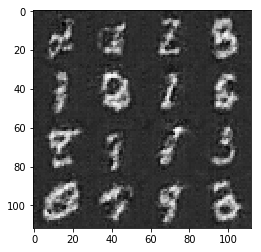

Epoch 2/2... Discriminator Loss: 0.0908... Generator Loss: 2.9228
Epoch 2/2... Discriminator Loss: 0.0855... Generator Loss: 3.1029
Epoch 2/2... Discriminator Loss: 0.0486... Generator Loss: 3.6167
Epoch 2/2... Discriminator Loss: 0.1094... Generator Loss: 2.7980
Epoch 2/2... Discriminator Loss: 0.0823... Generator Loss: 2.9478
Epoch 2/2... Discriminator Loss: 0.0998... Generator Loss: 2.6771
Epoch 2/2... Discriminator Loss: 0.1693... Generator Loss: 2.3337
Epoch 2/2... Discriminator Loss: 0.1344... Generator Loss: 2.4928
Epoch 2/2... Discriminator Loss: 0.0782... Generator Loss: 2.9408
Epoch 2/2... Discriminator Loss: 1.9584... Generator Loss: 0.3959


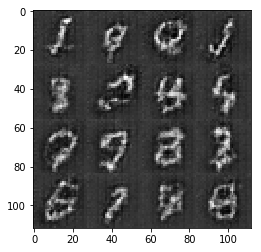

Epoch 2/2... Discriminator Loss: 1.6326... Generator Loss: 0.4668
Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 1.4168
Epoch 2/2... Discriminator Loss: 0.6474... Generator Loss: 1.3100
Epoch 2/2... Discriminator Loss: 0.4820... Generator Loss: 2.0839
Epoch 2/2... Discriminator Loss: 0.7559... Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 0.3688... Generator Loss: 1.6441
Epoch 2/2... Discriminator Loss: 0.3331... Generator Loss: 2.4426
Epoch 2/2... Discriminator Loss: 0.5236... Generator Loss: 2.6447
Epoch 2/2... Discriminator Loss: 0.4096... Generator Loss: 2.1986
Epoch 2/2... Discriminator Loss: 0.3196... Generator Loss: 2.1462


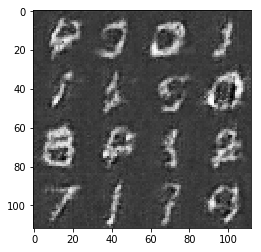

Epoch 2/2... Discriminator Loss: 0.2108... Generator Loss: 2.2399
Epoch 2/2... Discriminator Loss: 0.2955... Generator Loss: 3.2611
Epoch 2/2... Discriminator Loss: 0.3465... Generator Loss: 1.5708
Epoch 2/2... Discriminator Loss: 0.2459... Generator Loss: 2.3107
Epoch 2/2... Discriminator Loss: 0.2467... Generator Loss: 1.9589
Epoch 2/2... Discriminator Loss: 0.3333... Generator Loss: 1.5358
Epoch 2/2... Discriminator Loss: 0.2236... Generator Loss: 2.1007
Epoch 2/2... Discriminator Loss: 0.2255... Generator Loss: 3.9214
Epoch 2/2... Discriminator Loss: 0.1468... Generator Loss: 2.4645
Epoch 2/2... Discriminator Loss: 0.2254... Generator Loss: 3.5737


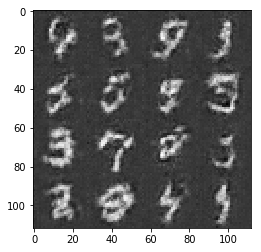

Epoch 2/2... Discriminator Loss: 0.2478... Generator Loss: 1.9104
Epoch 2/2... Discriminator Loss: 0.1158... Generator Loss: 2.9719
Epoch 2/2... Discriminator Loss: 0.1211... Generator Loss: 2.7090
Epoch 2/2... Discriminator Loss: 0.0847... Generator Loss: 2.9599
Epoch 2/2... Discriminator Loss: 0.1082... Generator Loss: 2.9546
Epoch 2/2... Discriminator Loss: 0.3916... Generator Loss: 1.4171
Epoch 2/2... Discriminator Loss: 0.0950... Generator Loss: 2.8498
Epoch 2/2... Discriminator Loss: 0.1257... Generator Loss: 2.6316
Epoch 2/2... Discriminator Loss: 0.0462... Generator Loss: 3.5076
Epoch 2/2... Discriminator Loss: 0.0662... Generator Loss: 3.2352


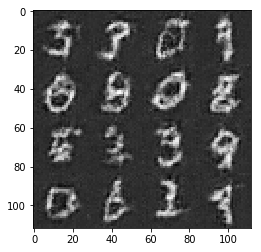

Epoch 2/2... Discriminator Loss: 0.0546... Generator Loss: 3.6275
Epoch 2/2... Discriminator Loss: 0.1547... Generator Loss: 2.2759
Epoch 2/2... Discriminator Loss: 0.0982... Generator Loss: 2.8871
Epoch 2/2... Discriminator Loss: 0.0646... Generator Loss: 3.2100
Epoch 2/2... Discriminator Loss: 0.1956... Generator Loss: 1.9901


IndexError: list index out of range

In [126]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 0.6243
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 0.4656
Epoch 1/2... Discriminator Loss: 0.3335... Generator Loss: 3.0900
Epoch 1/2... Discriminator Loss: 0.7725... Generator Loss: 0.7371
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 7.4790
Epoch 1/2... Discriminator Loss: 0.9689... Generator Loss: 0.5964
Epoch 1/2... Discriminator Loss: 0.3994... Generator Loss: 1.5414
Epoch 1/2... Discriminator Loss: 0.3516... Generator Loss: 2.7075
Epoch 1/2... Discriminator Loss: 0.5902... Generator Loss: 3.3250
Epoch 1/2... Discriminator Loss: 0.2337... Generator Loss: 2.0560


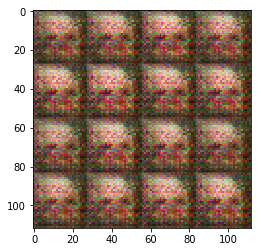

Epoch 1/2... Discriminator Loss: 0.3135... Generator Loss: 3.5569
Epoch 1/2... Discriminator Loss: 0.4353... Generator Loss: 3.2488
Epoch 1/2... Discriminator Loss: 0.4050... Generator Loss: 1.8215
Epoch 1/2... Discriminator Loss: 0.8417... Generator Loss: 0.9485
Epoch 1/2... Discriminator Loss: 1.1063... Generator Loss: 1.1388
Epoch 1/2... Discriminator Loss: 0.7390... Generator Loss: 1.1300
Epoch 1/2... Discriminator Loss: 0.7949... Generator Loss: 1.2337
Epoch 1/2... Discriminator Loss: 0.5680... Generator Loss: 1.3790
Epoch 1/2... Discriminator Loss: 0.5961... Generator Loss: 1.2995
Epoch 1/2... Discriminator Loss: 1.4207... Generator Loss: 3.3909


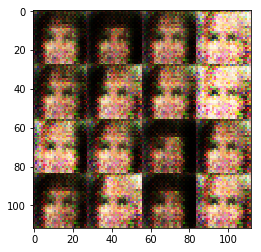

Epoch 1/2... Discriminator Loss: 1.0509... Generator Loss: 1.0743
Epoch 1/2... Discriminator Loss: 1.0353... Generator Loss: 0.7778
Epoch 1/2... Discriminator Loss: 0.7317... Generator Loss: 1.3114
Epoch 1/2... Discriminator Loss: 1.5363... Generator Loss: 5.0075
Epoch 1/2... Discriminator Loss: 0.5815... Generator Loss: 1.4459
Epoch 1/2... Discriminator Loss: 0.7658... Generator Loss: 1.4185
Epoch 1/2... Discriminator Loss: 0.7514... Generator Loss: 1.1910
Epoch 1/2... Discriminator Loss: 1.5403... Generator Loss: 0.3569
Epoch 1/2... Discriminator Loss: 0.9673... Generator Loss: 1.1207
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 1.0982


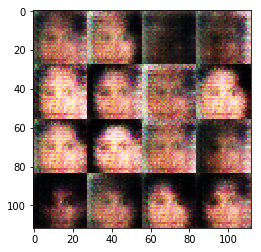

Epoch 1/2... Discriminator Loss: 0.7426... Generator Loss: 1.2723
Epoch 1/2... Discriminator Loss: 1.0817... Generator Loss: 0.7310
Epoch 1/2... Discriminator Loss: 0.8401... Generator Loss: 0.9846
Epoch 1/2... Discriminator Loss: 0.8868... Generator Loss: 0.9696
Epoch 1/2... Discriminator Loss: 1.0750... Generator Loss: 0.8525
Epoch 1/2... Discriminator Loss: 1.6799... Generator Loss: 0.3351
Epoch 1/2... Discriminator Loss: 1.0273... Generator Loss: 1.2028
Epoch 1/2... Discriminator Loss: 0.9891... Generator Loss: 1.7718
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 1.4468
Epoch 1/2... Discriminator Loss: 1.5670... Generator Loss: 0.4275


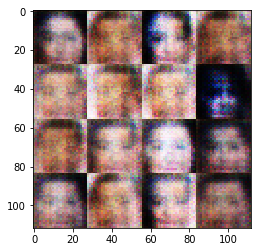

Epoch 1/2... Discriminator Loss: 0.9287... Generator Loss: 1.1880
Epoch 1/2... Discriminator Loss: 0.7940... Generator Loss: 1.1511
Epoch 1/2... Discriminator Loss: 1.1901... Generator Loss: 0.8459
Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 0.5648
Epoch 1/2... Discriminator Loss: 0.6349... Generator Loss: 2.2510
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 1.0857
Epoch 1/2... Discriminator Loss: 0.8368... Generator Loss: 1.2537
Epoch 1/2... Discriminator Loss: 1.0709... Generator Loss: 0.8499
Epoch 1/2... Discriminator Loss: 1.0670... Generator Loss: 1.1741
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 1.3340


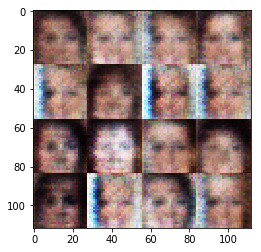

Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 0.7695
Epoch 1/2... Discriminator Loss: 1.0271... Generator Loss: 1.6432
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 0.7870
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 0.8883
Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 0.9656
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 1.1601
Epoch 1/2... Discriminator Loss: 1.1336... Generator Loss: 1.5020
Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 1.0211
Epoch 1/2... Discriminator Loss: 0.9923... Generator Loss: 1.3189
Epoch 1/2... Discriminator Loss: 0.9363... Generator Loss: 2.1264


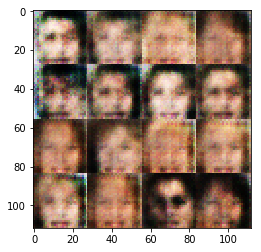

Epoch 1/2... Discriminator Loss: 1.7329... Generator Loss: 0.3965
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 0.9115
Epoch 1/2... Discriminator Loss: 1.0444... Generator Loss: 1.0901
Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 0.8101
Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 1.0637
Epoch 1/2... Discriminator Loss: 1.2620... Generator Loss: 0.9262
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.5194
Epoch 1/2... Discriminator Loss: 1.1412... Generator Loss: 0.9190
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 1.1420
Epoch 1/2... Discriminator Loss: 1.0787... Generator Loss: 0.8516


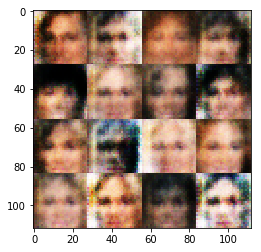

Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 0.6786
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 0.6811
Epoch 1/2... Discriminator Loss: 1.1446... Generator Loss: 0.8189
Epoch 1/2... Discriminator Loss: 1.4546... Generator Loss: 1.1168
Epoch 1/2... Discriminator Loss: 0.9707... Generator Loss: 0.9090
Epoch 1/2... Discriminator Loss: 1.1646... Generator Loss: 0.8480
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 0.6712
Epoch 1/2... Discriminator Loss: 1.1205... Generator Loss: 0.8665
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 0.8454
Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 0.7354


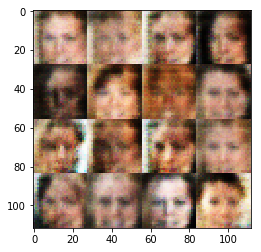

Epoch 1/2... Discriminator Loss: 1.2938... Generator Loss: 0.5738
Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 1.1353
Epoch 1/2... Discriminator Loss: 1.0264... Generator Loss: 1.1246
Epoch 1/2... Discriminator Loss: 1.0772... Generator Loss: 0.8025
Epoch 1/2... Discriminator Loss: 1.0975... Generator Loss: 1.1620
Epoch 1/2... Discriminator Loss: 1.1924... Generator Loss: 0.8239
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 0.9952
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 1.2388
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 0.9113
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 1.6472


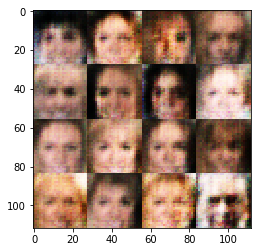

Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.7203
Epoch 1/2... Discriminator Loss: 1.2399... Generator Loss: 0.9044
Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 0.7854
Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.2317... Generator Loss: 0.6240
Epoch 1/2... Discriminator Loss: 1.0278... Generator Loss: 0.9905
Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 0.5484
Epoch 1/2... Discriminator Loss: 1.0969... Generator Loss: 0.8547
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 0.6320


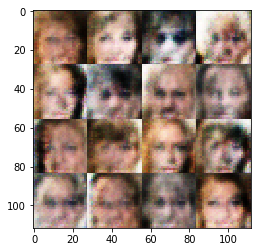

Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 1.2299
Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.5635
Epoch 1/2... Discriminator Loss: 1.2078... Generator Loss: 0.8938
Epoch 1/2... Discriminator Loss: 1.1295... Generator Loss: 0.7559
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 0.8878
Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 0.7914
Epoch 1/2... Discriminator Loss: 1.0389... Generator Loss: 0.8390
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.6380
Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 0.8077
Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 0.8101


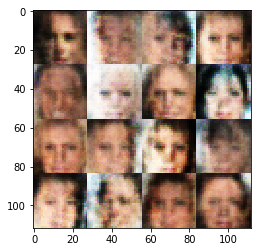

Epoch 1/2... Discriminator Loss: 1.2142... Generator Loss: 0.5462
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.5914
Epoch 1/2... Discriminator Loss: 1.0642... Generator Loss: 1.1360
Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 1.4464
Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 0.9555
Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 0.6497
Epoch 1/2... Discriminator Loss: 1.1899... Generator Loss: 0.6595
Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 0.5692
Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 0.5602
Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 0.6579


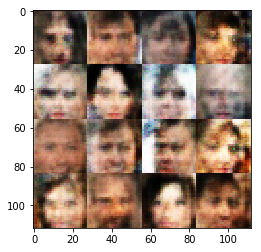

Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 0.6880
Epoch 1/2... Discriminator Loss: 1.2186... Generator Loss: 0.7231
Epoch 1/2... Discriminator Loss: 1.2153... Generator Loss: 0.7475
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.4343
Epoch 1/2... Discriminator Loss: 1.1020... Generator Loss: 1.0050
Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 0.4256
Epoch 1/2... Discriminator Loss: 1.2383... Generator Loss: 0.6736
Epoch 1/2... Discriminator Loss: 1.3907... Generator Loss: 0.7970
Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 1.2982... Generator Loss: 0.7825


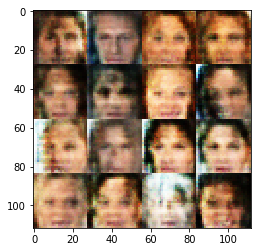

Epoch 1/2... Discriminator Loss: 1.2095... Generator Loss: 0.6418
Epoch 1/2... Discriminator Loss: 1.2665... Generator Loss: 1.0330
Epoch 1/2... Discriminator Loss: 1.2157... Generator Loss: 0.8045
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 0.5743
Epoch 1/2... Discriminator Loss: 1.2987... Generator Loss: 0.7542
Epoch 1/2... Discriminator Loss: 1.2982... Generator Loss: 0.6390
Epoch 1/2... Discriminator Loss: 1.1364... Generator Loss: 1.0773
Epoch 1/2... Discriminator Loss: 1.1963... Generator Loss: 1.0023
Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 0.8341
Epoch 1/2... Discriminator Loss: 1.0855... Generator Loss: 1.0106


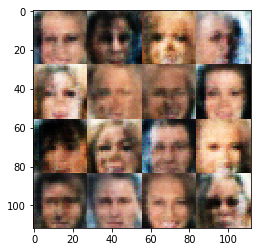

Epoch 1/2... Discriminator Loss: 1.3231... Generator Loss: 0.5056
Epoch 1/2... Discriminator Loss: 1.3110... Generator Loss: 0.6044
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 0.6375
Epoch 1/2... Discriminator Loss: 1.4710... Generator Loss: 0.4141
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.5927
Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 0.7150
Epoch 1/2... Discriminator Loss: 1.2737... Generator Loss: 0.5876
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 0.6699
Epoch 1/2... Discriminator Loss: 1.1624... Generator Loss: 1.3276
Epoch 1/2... Discriminator Loss: 1.1806... Generator Loss: 0.8695


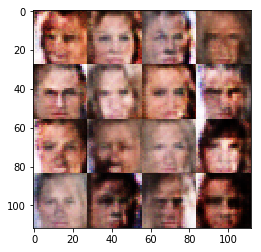

Epoch 1/2... Discriminator Loss: 1.3360... Generator Loss: 0.9783
Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 0.6318
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.6742
Epoch 1/2... Discriminator Loss: 1.1749... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 1.1975... Generator Loss: 0.7111
Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 1.0335
Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 0.8286
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 0.8534
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 0.6736
Epoch 1/2... Discriminator Loss: 1.1266... Generator Loss: 0.9399


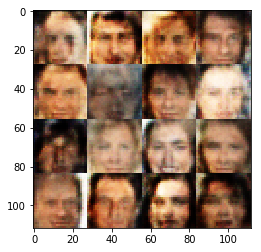

Epoch 1/2... Discriminator Loss: 1.1849... Generator Loss: 0.7650
Epoch 1/2... Discriminator Loss: 1.1494... Generator Loss: 0.9553
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 1.1885
Epoch 1/2... Discriminator Loss: 1.2300... Generator Loss: 1.2167
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 1.0633
Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 1.1850... Generator Loss: 0.7810
Epoch 1/2... Discriminator Loss: 1.3446... Generator Loss: 1.2061
Epoch 1/2... Discriminator Loss: 1.3989... Generator Loss: 0.4700
Epoch 1/2... Discriminator Loss: 1.2570... Generator Loss: 0.7637


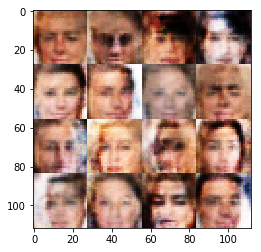

Epoch 1/2... Discriminator Loss: 1.2328... Generator Loss: 0.7458
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.6393
Epoch 1/2... Discriminator Loss: 1.2649... Generator Loss: 0.9468
Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 0.9546
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 0.8743
Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 1.0308
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 0.9024
Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 0.6487
Epoch 1/2... Discriminator Loss: 1.1653... Generator Loss: 0.6758


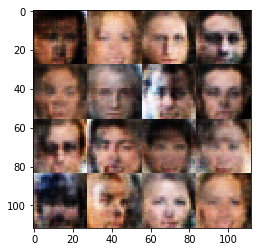

Epoch 1/2... Discriminator Loss: 1.2304... Generator Loss: 0.6913
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 0.9471
Epoch 1/2... Discriminator Loss: 1.0654... Generator Loss: 1.0766
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 0.8306
Epoch 1/2... Discriminator Loss: 1.1015... Generator Loss: 0.9867
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 1.2522... Generator Loss: 0.9629
Epoch 1/2... Discriminator Loss: 1.2651... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 1.2175... Generator Loss: 1.1394
Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 0.8406


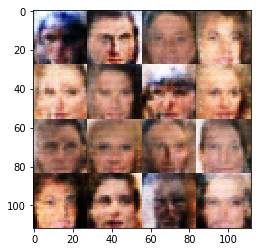

Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.6291
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 0.5603
Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 0.8685
Epoch 1/2... Discriminator Loss: 1.2627... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 0.8514


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.